In [1]:
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm


In [2]:
df1 = pd.read_csv("results/selected_30B_0.csv")
df2 = pd.read_csv("results/selected_30B_1.csv")
df3 = pd.read_csv("results/selected_30B_2.csv")
df4 = pd.read_csv("results/selected_30B_3.csv")
df = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)
# drop duplicate orig_index row in df
df.drop_duplicates(subset='orig_index',inplace=True)
df.to_csv('results/30B_llm_result_47K.csv', index=False)
# previous_df = pd.read_csv("results/02_ai_scores_v2.csv")
# # concat previous_df ['ai_score', 'keyword_score'] to df based on orig_index to previous_df index
# df = df.merge(previous_df[['ai_score', 'keyword_score']], left_on='orig_index', right_index=True, how='left')
df.dropna(inplace=True,subset=["is_ai_llm"])

# df = df[df['is_ai_llm']]
print(df.shape)
print(df.columns)
df.describe()
# only keep year larger than 2015
df = df[pd.to_datetime(df["published_date"], errors='coerce').dt.year >= 2016]




(47762, 20)
Index(['plain_text', 'published_date', 'title', 'tags', 'categories', 'author',
       'sitename', 'publisher', 'orig_index', 'is_ai_llm', 'ai_relevance_llm',
       'ai_topic_llm', 'ai_barrier_llm', 'ai_barrier_type_llm',
       'ai_barrier_summary_llm', 'countries_llm', 'cities_llm',
       'industries_llm', 'ai_terms_llm', 'ai_evidence_llm'],
      dtype='object')


In [22]:
df.to_csv('results/30B_llm_result_47K.csv', index=False)


Shape: (47762, 20)
Columns: ['plain_text', 'published_date', 'title', 'tags', 'categories', 'author', 'sitename', 'publisher', 'orig_index', 'is_ai_llm', 'ai_relevance_llm', 'ai_topic_llm', 'ai_barrier_llm', 'ai_barrier_type_llm', 'ai_barrier_summary_llm', 'countries_llm', 'cities_llm', 'industries_llm', 'ai_terms_llm', 'ai_evidence_llm']

=== Basic info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47762 entries, 0 to 47761
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   plain_text              47762 non-null  object        
 1   published_date          47762 non-null  datetime64[ns]
 2   title                   47762 non-null  object        
 3   tags                    13525 non-null  object        
 4   categories              24948 non-null  object        
 5   author                  42914 non-null  object        
 6   sitename                47762 non-null  objec

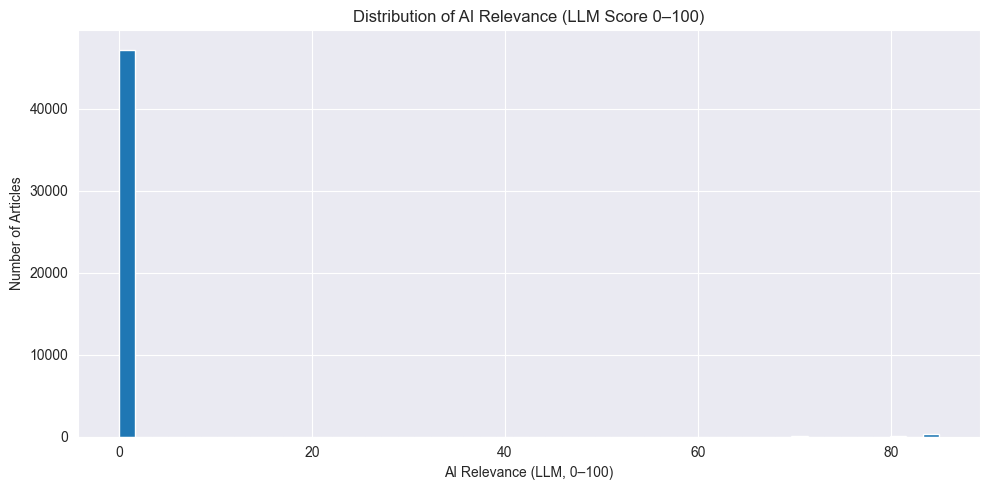

Saved: figures_ai_llm_overview\01_ai_relevance_distribution.png


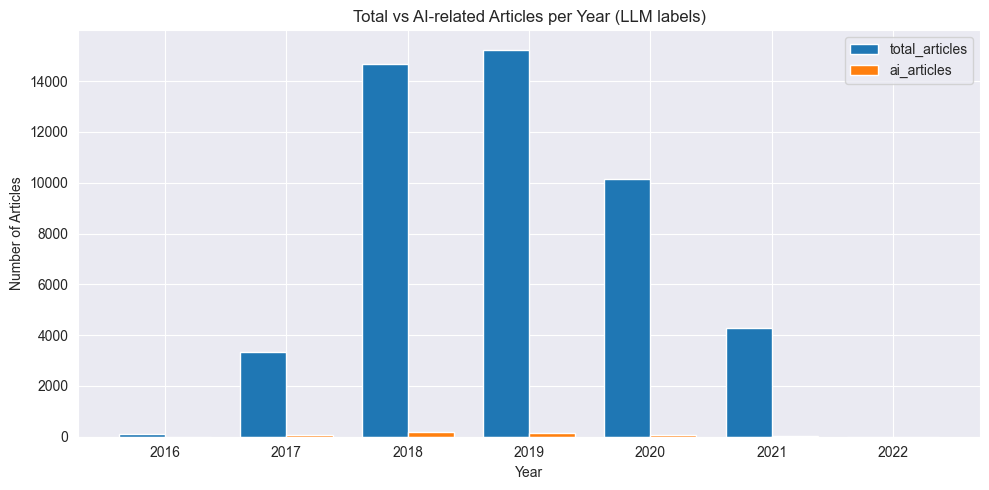

Saved: figures_ai_llm_overview\04_yearly_total_vs_ai.png


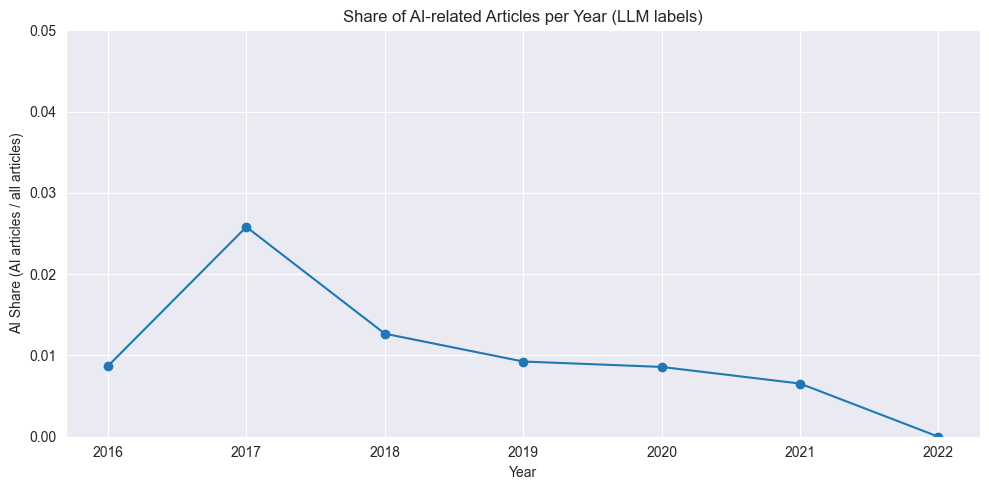

Saved: figures_ai_llm_overview\05_yearly_ai_share.png


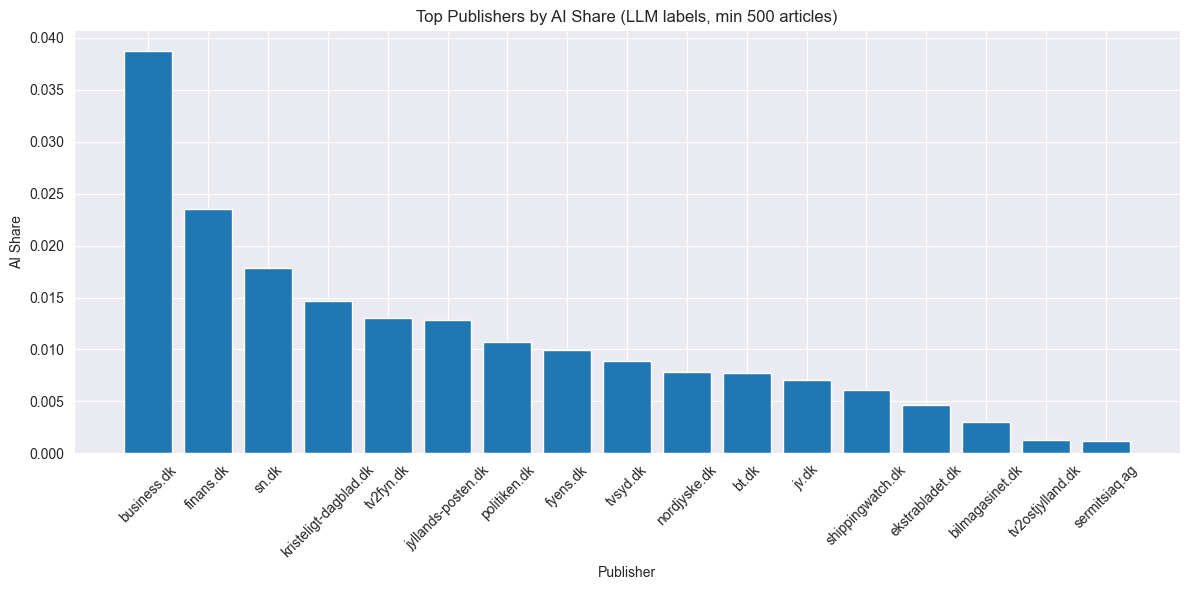

Saved: figures_ai_llm_overview\06_publisher_ai_share.png


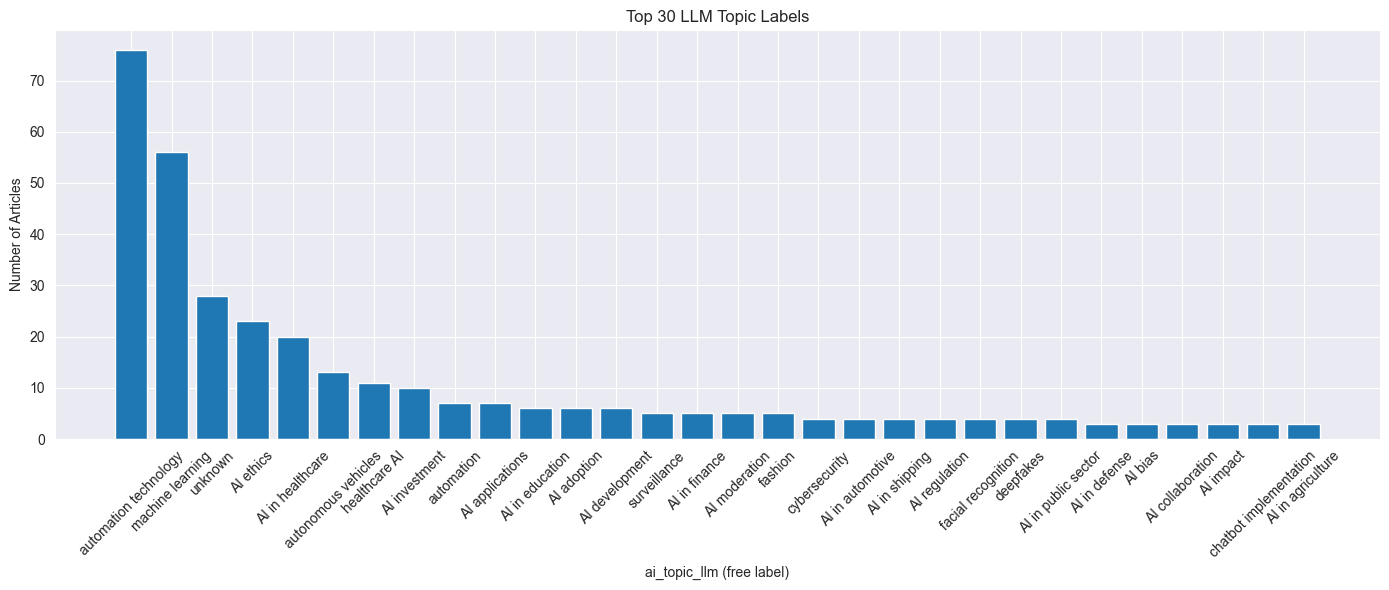

Saved: figures_ai_llm_overview\07_topic_distribution.png


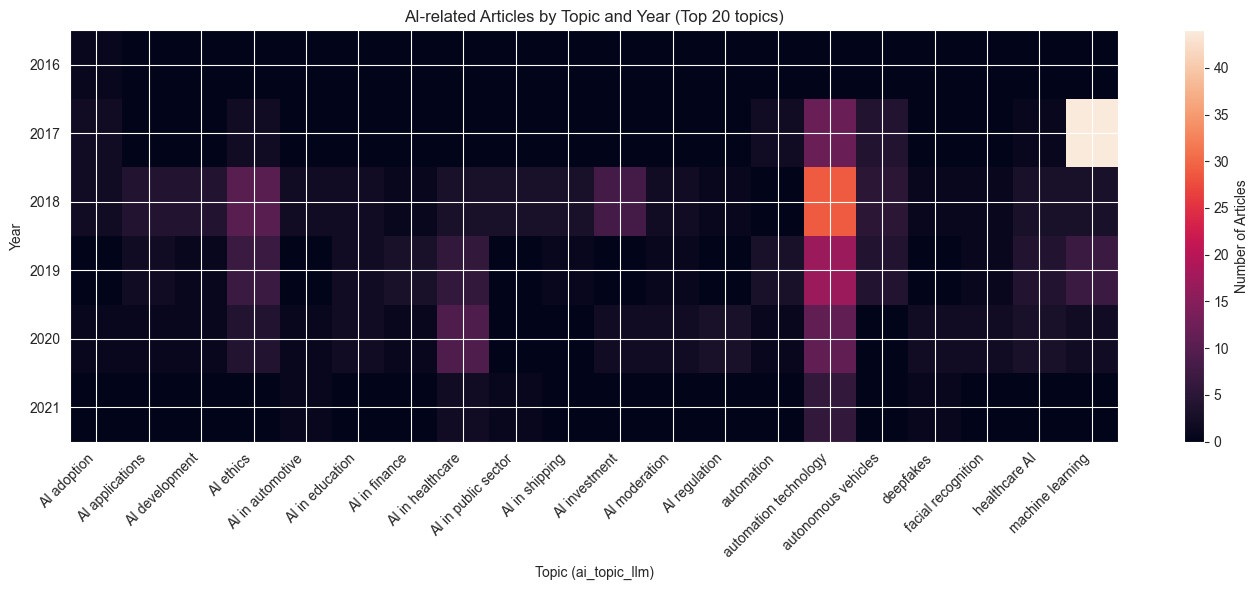

Saved: figures_ai_llm_overview\08_topic_year_heatmap.png


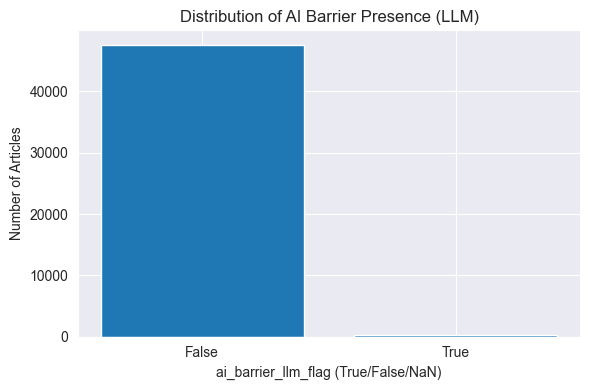

Saved: figures_ai_llm_overview\09_barrier_presence_distribution.png


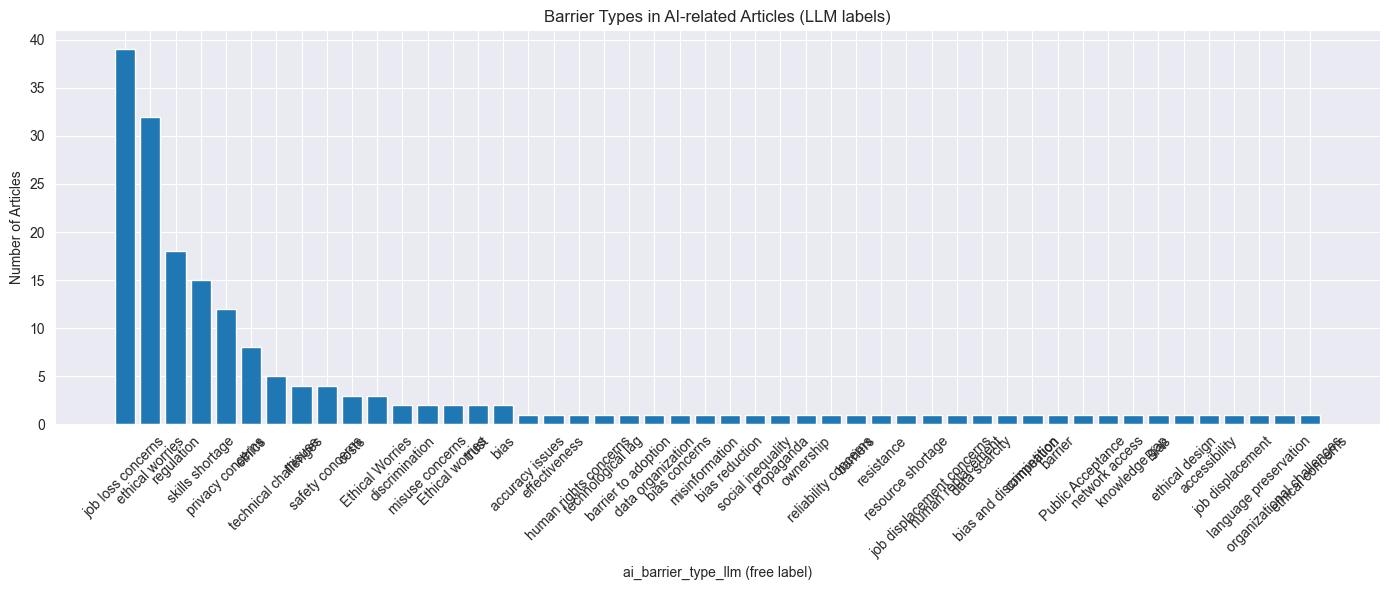

Saved: figures_ai_llm_overview\10_barrier_type_distribution.png


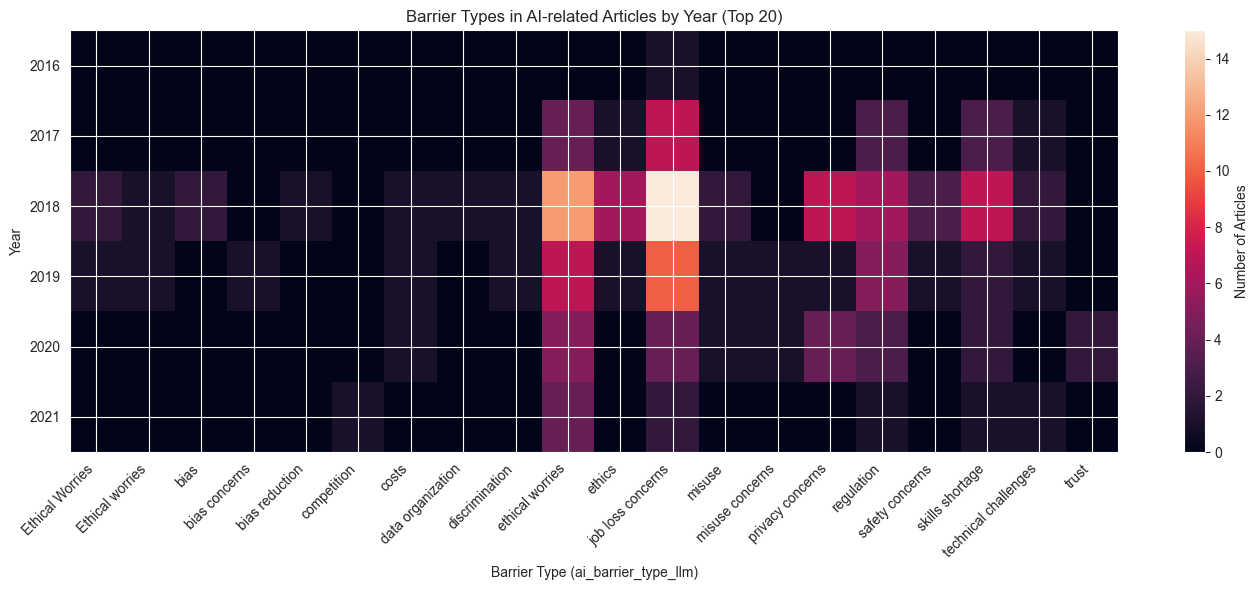

Saved: figures_ai_llm_overview\11_barrier_type_year_heatmap.png

All figures saved under: figures_ai_llm_overview


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# 0. Assume df is already loaded & concatenated
# =====================================================
# You said you already did:
# df1 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_1_v2.csv")
# df2 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_2_v2.csv")
# df3 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_3_v2.csv")
# df4 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_4_v2.csv")  # <- small fix: shard_4, not 3
# df = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)

# If not, uncomment and fix paths:
# df1 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_1_v2.csv")
# df2 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_2_v2.csv")
# df3 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_3_v2.csv")
# df4 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_4_v2.csv")
# df = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Directory for figures (PNG)
FIG_DIR = "figures_ai_llm_overview"
os.makedirs(FIG_DIR, exist_ok=True)

# =====================================================
# 1. Basic cleaning & helpers
# =====================================================

# 1.1 Parse dates and extract year
if "published_date" in df.columns:
    df["published_date"] = pd.to_datetime(df["published_date"], errors="coerce")
    df["year"] = df["published_date"].dt.year
else:
    df["year"] = np.nan


def to_bool_series(series: pd.Series) -> pd.Series:
    """
    Robust boolean conversion:
    - true:  True, 1, "1", "true", "True", "ja", "yes"
    - false: False, 0, "0", "false", "False", "nej", "no"
    - others: NaN
    """
    s = series.astype(str).str.strip().str.lower()
    true_vals = {"1", "true", "ja", "yes"}
    false_vals = {"0", "false", "nej", "no"}

    def _map_val(v: str):
        if v in true_vals:
            return True
        if v in false_vals:
            return False
        return np.nan

    return s.map(_map_val)


# 1.2 Convert LLM AI flag to boolean
if "is_ai_llm" in df.columns:
    df["is_ai_llm_flag"] = to_bool_series(df["is_ai_llm"])
else:
    df["is_ai_llm_flag"] = np.nan

if "is_ai" in df.columns:
    df["is_ai_flag"] = to_bool_series(df["is_ai"])
else:
    df["is_ai_flag"] = np.nan

# 1.3 Ensure relevance score is numeric
if "ai_relevance_llm" in df.columns:
    df["ai_relevance_llm"] = pd.to_numeric(df["ai_relevance_llm"], errors="coerce")

# 1.4 Ensure barrier flag is boolean
if "ai_barrier_llm" in df.columns:
    df["ai_barrier_llm_flag"] = to_bool_series(df["ai_barrier_llm"])
else:
    df["ai_barrier_llm_flag"] = np.nan

# =====================================================
# 2. Basic descriptive statistics (printed)
# =====================================================

print("\n=== Basic info ===")
print(df.info())

print("\n=== Missing value ratio per column ===")
missing_ratio = df.isna().mean().sort_values(ascending=False)
print(missing_ratio)

print("\n=== Numeric describe ===")
print(df.describe())

print("\n=== Example topic / barrier columns head ===")
cols_preview = [
    "orig_index",
    "published_date",
    "sitename",
    "publisher",
    "is_ai_llm_flag",
    "ai_relevance_llm",
    "ai_topic_llm",
    "ai_barrier_llm_flag",
    "ai_barrier_type_llm",
]
cols_preview = [c for c in cols_preview if c in df.columns]
print(df[cols_preview].head(10))

# =====================================================
# Plot helpers
# =====================================================


def _save_show_close(fig: plt.Figure, filename: str, dpi: int = 200):
    """Save to FIG_DIR as PNG, show in notebook, then close to free memory."""
    out_path = os.path.join(FIG_DIR, filename)
    fig.tight_layout()
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Saved:", out_path)


# =====================================================
# 3. Distribution of AI relevance scores (hist)
# =====================================================

if "ai_relevance_llm" in df.columns:
    x = df["ai_relevance_llm"].dropna()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(x, bins=50)
    ax.set_title("Distribution of AI Relevance (LLM Score 0–100)")
    ax.set_xlabel("AI Relevance (LLM, 0–100)")
    ax.set_ylabel("Number of Articles")
    _save_show_close(fig, "01_ai_relevance_distribution.png")

# =====================================================
# 4. Relationship: ai_score / keyword_score vs LLM relevance (scatter)
# =====================================================

MAX_POINTS_SCATTER = 50_000
need_cols = [c for c in ["ai_relevance_llm", "ai_score", "keyword_score"] if c in df.columns]
if "ai_relevance_llm" in need_cols:
    scatter_df = df[need_cols].copy().dropna()
    if len(scatter_df) > MAX_POINTS_SCATTER:
        scatter_df = scatter_df.sample(MAX_POINTS_SCATTER, random_state=42)

    if "ai_score" in scatter_df.columns:
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(scatter_df["ai_score"], scatter_df["ai_relevance_llm"], s=6, alpha=0.4)
        ax.set_title("SBERT AI Score vs LLM AI Relevance")
        ax.set_xlabel("ai_score (SBERT-based)")
        ax.set_ylabel("ai_relevance_llm (0–100)")
        _save_show_close(fig, "02_sbert_vs_llm_relevance.png")

    if "keyword_score" in scatter_df.columns:
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(scatter_df["keyword_score"], scatter_df["ai_relevance_llm"], s=6, alpha=0.4)
        ax.set_title("Keyword Score vs LLM AI Relevance")
        ax.set_xlabel("keyword_score")
        ax.set_ylabel("ai_relevance_llm (0–100)")
        _save_show_close(fig, "03_keyword_vs_llm_relevance.png")

# =====================================================
# 5. Yearly trends: total vs AI vs AI share
# =====================================================

if "year" in df.columns and "orig_index" in df.columns:
    if "is_ai_llm_flag" in df.columns:
        yearly = (
            df.groupby("year", dropna=True)
            .agg(
                total_articles=("orig_index", "count"),
                ai_articles=("is_ai_llm_flag", lambda s: s.fillna(False).astype(int).sum()),
            )
            .reset_index()
        )
    else:
        yearly = df.groupby("year", dropna=True).agg(total_articles=("orig_index", "count")).reset_index()
        yearly["ai_articles"] = 0

    yearly["ai_share"] = np.where(
        yearly["total_articles"] > 0, yearly["ai_articles"] / yearly["total_articles"], np.nan
    )

    # 5.1 Total vs AI articles per year (grouped bars)
    fig, ax = plt.subplots(figsize=(10, 5))
    years = yearly["year"].astype(int).tolist()
    x = np.arange(len(years))
    width = 0.38
    ax.bar(x - width / 2, yearly["total_articles"], width=width, label="total_articles")
    ax.bar(x + width / 2, yearly["ai_articles"], width=width, label="ai_articles")
    ax.set_title("Total vs AI-related Articles per Year (LLM labels)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of Articles")
    ax.set_xticks(x)
    ax.set_xticklabels(years, rotation=0)
    ax.legend()
    _save_show_close(fig, "04_yearly_total_vs_ai.png")

    # 5.2 AI share per year (line)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(yearly["year"], yearly["ai_share"], marker="o")
    ax.set_title("Share of AI-related Articles per Year (LLM labels)")
    ax.set_xlabel("Year")
    ax.set_ylabel("AI Share (AI articles / all articles)")
    if np.isfinite(np.nanmax(yearly["ai_share"])):
        ax.set_ylim(0, max(0.05, np.nanmax(yearly["ai_share"]) * 1.05))
    _save_show_close(fig, "05_yearly_ai_share.png")

# =====================================================
# 6. AI share per publisher
# =====================================================

if "publisher" in df.columns and "orig_index" in df.columns and "is_ai_llm_flag" in df.columns:
    tmp = df[["publisher", "orig_index", "is_ai_llm_flag"]].copy()
    tmp["ai_int"] = tmp["is_ai_llm_flag"].fillna(False).astype(int)

    publisher_stats = (
        tmp.groupby("publisher")
        .agg(total_articles=("orig_index", "count"), ai_articles=("ai_int", "sum"))
        .reset_index()
    )
    publisher_stats["ai_share"] = publisher_stats["ai_articles"] / publisher_stats["total_articles"]

    MIN_ARTICLES = 500
    publisher_stats = publisher_stats[publisher_stats["total_articles"] >= MIN_ARTICLES]
    publisher_stats = publisher_stats.sort_values("ai_share", ascending=False).head(20)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(publisher_stats["publisher"], publisher_stats["ai_share"])
    ax.set_title("Top Publishers by AI Share (LLM labels, min 500 articles)")
    ax.set_xlabel("Publisher")
    ax.set_ylabel("AI Share")
    ax.tick_params(axis="x", rotation=45)
    _save_show_close(fig, "06_publisher_ai_share.png")

# =====================================================
# 7. Topic distribution (ai_topic_llm)
# =====================================================

if "ai_topic_llm" in df.columns:
    topic_counts = (
        df["ai_topic_llm"]
        .astype(str)
        .str.strip()
        .replace("", np.nan)
        .dropna()
        .value_counts()
        .reset_index()
    )
    topic_counts.columns = ["ai_topic_llm", "count"]
    topic_counts = topic_counts[~topic_counts["ai_topic_llm"].str.lower().isin(["none", "nan", "other"])]

    TOP_N_TOPICS = 30
    topic_counts_top = topic_counts.head(TOP_N_TOPICS)

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(topic_counts_top["ai_topic_llm"], topic_counts_top["count"])
    ax.set_title(f"Top {TOP_N_TOPICS} LLM Topic Labels")
    ax.set_xlabel("ai_topic_llm (free label)")
    ax.set_ylabel("Number of Articles")
    ax.tick_params(axis="x", rotation=45)
    _save_show_close(fig, "07_topic_distribution.png")

# =====================================================
# 8. Topic × Year heatmap
# =====================================================

if {"ai_topic_llm", "year", "is_ai_llm_flag", "orig_index"}.issubset(df.columns):
    topic_year = (
        df[df["is_ai_llm_flag"] == True]
        .groupby(["year", "ai_topic_llm"])
        .agg(n=("orig_index", "count"))
        .reset_index()
    )

    top_topics = (
        topic_year.groupby("ai_topic_llm")["n"].sum().sort_values(ascending=False).head(20).index.tolist()
    )
    topic_year = topic_year[topic_year["ai_topic_llm"].isin(top_topics)]
    heat = topic_year.pivot_table(index="year", columns="ai_topic_llm", values="n", fill_value=0)

    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(heat.values, aspect="auto")
    ax.set_title("AI-related Articles by Topic and Year (Top 20 topics)")
    ax.set_xlabel("Topic (ai_topic_llm)")
    ax.set_ylabel("Year")
    ax.set_xticks(np.arange(len(heat.columns)))
    ax.set_xticklabels(heat.columns.tolist(), rotation=45, ha="right")
    ax.set_yticks(np.arange(len(heat.index)))
    ax.set_yticklabels(heat.index.astype(int).tolist())
    fig.colorbar(im, ax=ax, label="Number of Articles")
    _save_show_close(fig, "08_topic_year_heatmap.png")

# =====================================================
# 9. Barrier analysis
# =====================================================

# 9.1 Barrier presence distribution
if "ai_barrier_llm_flag" in df.columns:
    barrier_counts = df["ai_barrier_llm_flag"].value_counts(dropna=False)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(barrier_counts.index.astype(str), barrier_counts.values)
    ax.set_title("Distribution of AI Barrier Presence (LLM)")
    ax.set_xlabel("ai_barrier_llm_flag (True/False/NaN)")
    ax.set_ylabel("Number of Articles")
    _save_show_close(fig, "09_barrier_presence_distribution.png")

# 9.2 Barrier type distribution (for AI-related + has_barrier)
if {"ai_barrier_type_llm", "is_ai_llm_flag", "ai_barrier_llm_flag"}.issubset(df.columns):
    barrier_type_df = df[(df["is_ai_llm_flag"] == True) & (df["ai_barrier_llm_flag"] == True)].copy()

    barrier_type_counts = (
        barrier_type_df["ai_barrier_type_llm"]
        .astype(str)
        .str.strip()
        .replace("", np.nan)
        .dropna()
        .value_counts()
        .reset_index()
    )
    barrier_type_counts.columns = ["ai_barrier_type_llm", "count"]

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(barrier_type_counts["ai_barrier_type_llm"], barrier_type_counts["count"])
    ax.set_title("Barrier Types in AI-related Articles (LLM labels)")
    ax.set_xlabel("ai_barrier_type_llm (free label)")
    ax.set_ylabel("Number of Articles")
    ax.tick_params(axis="x", rotation=45)
    _save_show_close(fig, "10_barrier_type_distribution.png")

# 9.3 Barrier type × Year heatmap
if {"ai_barrier_type_llm", "year", "is_ai_llm_flag", "ai_barrier_llm_flag", "orig_index"}.issubset(df.columns):
    barrier_year = (
        df[(df["is_ai_llm_flag"] == True) & (df["ai_barrier_llm_flag"] == True)]
        .groupby(["year", "ai_barrier_type_llm"])
        .agg(n=("orig_index", "count"))
        .reset_index()
    )

    top_barriers = (
        barrier_year.groupby("ai_barrier_type_llm")["n"].sum().sort_values(ascending=False).head(20).index.tolist()
    )
    barrier_year = barrier_year[barrier_year["ai_barrier_type_llm"].isin(top_barriers)]
    heat_b = barrier_year.pivot_table(index="year", columns="ai_barrier_type_llm", values="n", fill_value=0)

    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(heat_b.values, aspect="auto")
    ax.set_title("Barrier Types in AI-related Articles by Year (Top 20)")
    ax.set_xlabel("Barrier Type (ai_barrier_type_llm)")
    ax.set_ylabel("Year")
    ax.set_xticks(np.arange(len(heat_b.columns)))
    ax.set_xticklabels(heat_b.columns.tolist(), rotation=45, ha="right")
    ax.set_yticks(np.arange(len(heat_b.index)))
    ax.set_yticklabels(heat_b.index.astype(int).tolist())
    fig.colorbar(im, ax=ax, label="Number of Articles")
    _save_show_close(fig, "11_barrier_type_year_heatmap.png")

print("\nAll figures saved under:", FIG_DIR)



In [5]:
df.shape

(47762, 24)

In [6]:
# using umap and hdbscan to cluster articles based on their embeddings and see if clusters correspond to ai_llm labels
from umap import UMAP
ai_df = df[df['is_ai_llm']]

emb = np.load("results/01_embeddings.npy")
# emb select by df orig_index
emb = emb[ai_df["orig_index"].values]

reduced = UMAP(n_neighbors=15, min_dist=0.0, metric="cosine").fit_transform(emb)
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, metric='euclidean')
labels = clusterer.fit_predict(reduced)
ai_df["cluster"] = labels


E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\qswwq\AppData\Local\Temp\ipykernel_7940\321226441.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [7]:
labels

array([ 2,  2,  0, -1,  1,  2, -1, -1,  3,  3,  3,  2,  2,  2, -1,  3,  3,
        3,  3,  3,  3,  3,  3, -1,  3,  3,  3,  3,  3,  2, -1,  1,  1,  1,
        1,  1, -1,  1,  2, -1,  2, -1,  2,  2,  2,  2,  1, -1, -1,  2,  1,
        2,  2,  2,  2,  2,  1, -1, -1,  2,  2,  0,  1,  2,  1,  2,  2,  2,
        1,  0,  1, -1,  2, -1,  2,  2,  2,  2,  2,  2,  2,  1, -1, -1,  2,
        1,  2,  1,  0,  0, -1,  1,  2,  2,  2, -1,  2,  2,  2, -1,  2,  2,
        1,  1,  2, -1,  2,  2,  1,  2,  2,  2,  1,  0,  2,  2,  2,  1,  2,
        2,  2, -1,  1,  0,  0,  2,  0,  2,  2, -1,  0,  2,  2,  2,  2,  0,
        2,  2,  3, -1,  1,  1,  3,  3,  3,  3,  3,  3,  3,  1,  3,  1,  2,
        1,  0, -1,  2,  2,  2,  2,  1, -1,  2,  2,  2,  2,  0,  2,  2,  1,
       -1,  1,  2,  1,  0,  1,  2, -1,  2,  1, -1,  1,  1, -1,  1,  1, -1,
        1,  2, -1,  2, -1,  2,  2,  2,  1,  2, -1, -1,  2,  2,  2,  2,  2,
        2, -1,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  1,  1, -1, -1,  1,
        2,  2,  2,  0,  2

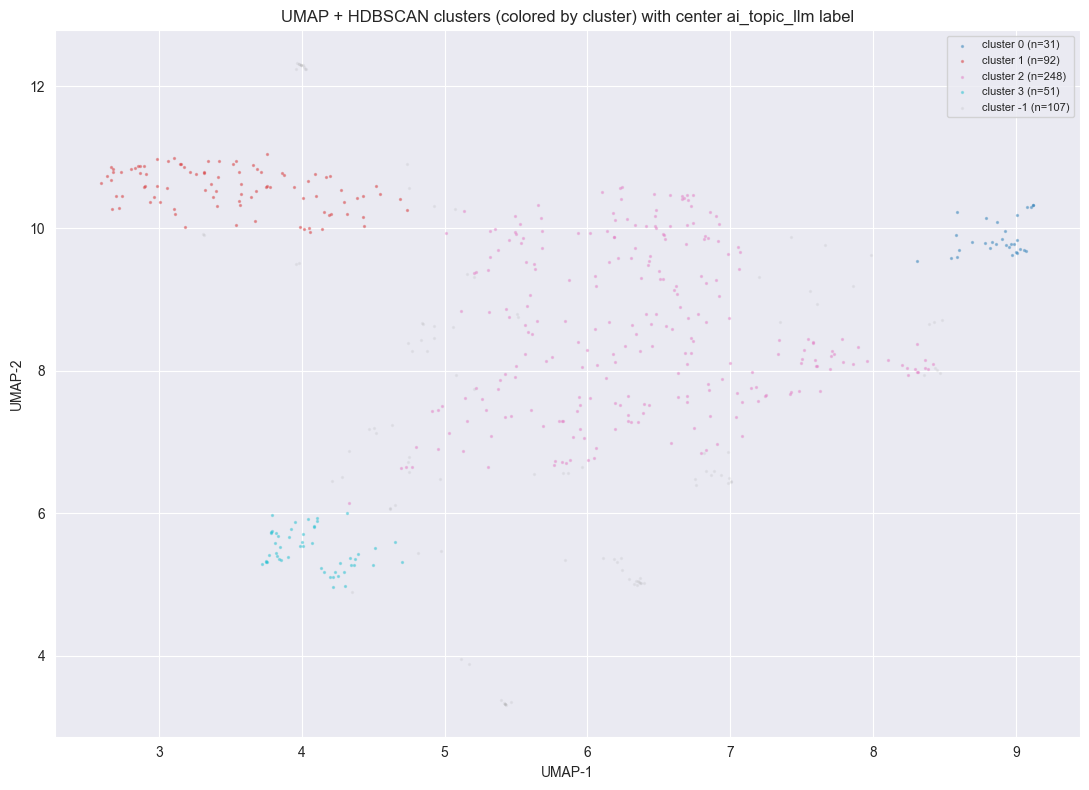

[ 2  2  0 -1  1  2 -1 -1  3  3  3  2  2  2 -1  3  3  3  3  3  3  3  3 -1
  3  3  3  3  3  2 -1  1  1  1  1  1 -1  1  2 -1  2 -1  2  2  2  2  1 -1
 -1  2  1  2  2  2  2  2  1 -1 -1  2  2  0  1  2  1  2  2  2  1  0  1 -1
  2 -1  2  2  2  2  2  2  2  1 -1 -1  2  1  2  1  0  0 -1  1  2  2  2 -1
  2  2  2 -1  2  2  1  1  2 -1  2  2  1  2  2  2  1  0  2  2  2  1  2  2
  2 -1  1  0  0  2  0  2  2 -1  0  2  2  2  2  0  2  2  3 -1  1  1  3  3
  3  3  3  3  3  1  3  1  2  1  0 -1  2  2  2  2  1 -1  2  2  2  2  0  2
  2  1 -1  1  2  1  0  1  2 -1  2  1 -1  1  1 -1  1  1 -1  1  2 -1  2 -1
  2  2  2  1  2 -1 -1  2  2  2  2  2  2 -1  2  2  2  2  2  2  1  2  2  2
  1  1 -1 -1  1  2  2  2  0  2  2 -1 -1  1  2  2  2  2  2  2  1  0  2  0
 -1 -1  2  2  2  2  2  2  2  2  2  2  0  2  2  2  2 -1  0  2  0  2 -1  2
  2  2  2 -1  3  1  2  1  1  2  2  3  2  2  2  2  3  3  3 -1  3  2  3  3
  3  3  3  3  1 -1  2 -1  2  2 -1  3 -1  2  1  1  2  1 -1  2  2 -1 -1  2
  2  1 -1  1  2  2 -1 -1 -1  1  1  1  2  2  1 -1  2

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Safety alignment
# -----------------------
ai_df = ai_df.copy().reset_index(drop=True)  # 重要：确保 reduced[i] 对应 ai_df.iloc[i]

CLUSTER_COL = "cluster"
TOPIC_COL = "ai_topic_llm"

assert reduced.shape[0] == len(ai_df), "reduced and ai_df length mismatch"
assert CLUSTER_COL in ai_df.columns, f"missing {CLUSTER_COL}"
assert TOPIC_COL in ai_df.columns, f"missing {TOPIC_COL}"

# -----------------------
# Plot params
# -----------------------
MAX_PTS = 200_000     # 点太多就抽样（60k不用抽也行）
RNG = 42
LABEL_MAX_CHARS = 26  # 标签太长截断
MIN_LABEL_N = 300     # 小簇不标注

N = len(ai_df)
idx = np.arange(N)
if N > MAX_PTS:
    idx = np.random.default_rng(RNG).choice(N, size=MAX_PTS, replace=False)

x = reduced[idx, 0]
y = reduced[idx, 1]
clusters = ai_df.loc[idx, CLUSTER_COL].to_numpy()

# unique clusters (keep -1 last)
uniq = np.unique(ai_df[CLUSTER_COL].to_numpy())
uniq = [c for c in uniq if c != -1] + ([-1] if -1 in uniq else [])

# color map for non-noise clusters
k = len([c for c in uniq if c != -1])
palette = plt.cm.tab10(np.linspace(0, 1, max(k, 3)))
color_map = {}
pi = 0
for c in uniq:
    if c == -1:
        color_map[c] = (0.6, 0.6, 0.6, 0.15)  # noise gray
    else:
        color_map[c] = palette[pi]
        pi += 1

# -----------------------
# Compute cluster centers + majority ai_topic_llm (on FULL data, not just sampled)
# -----------------------
centers = {}
labels_text = {}

for c in uniq:
    m_full = (ai_df[CLUSTER_COL].to_numpy() == c)
    if m_full.sum() == 0:
        continue

    cx = reduced[m_full, 0].mean()
    cy = reduced[m_full, 1].mean()
    centers[c] = (cx, cy)

    # majority topic label
    vc = ai_df.loc[m_full, TOPIC_COL].astype(str).value_counts()
    major = vc.index[0] if len(vc) else ""
    share = float(vc.iloc[0] / vc.sum()) if len(vc) else 0.0

    # shorten
    major2 = major.replace("\n", " ").strip()
    if len(major2) > LABEL_MAX_CHARS:
        major2 = major2[:LABEL_MAX_CHARS] + "…"

    labels_text[c] = f"{major2} ({share:.0%})"

# -----------------------
# Plot
# -----------------------
fig, ax = plt.subplots(figsize=(11, 8))

for c in uniq:
    m = (clusters == c)
    if m.sum() == 0:
        continue
    ax.scatter(
        x[m], y[m],
        s=2,
        alpha=0.35 if c != -1 else 0.10,
        c=[color_map[c]],
        label=f"cluster {c} (n={int((ai_df[CLUSTER_COL]==c).sum())})",
        rasterized=True
    )

ax.set_title("UMAP + HDBSCAN clusters (colored by cluster) with center ai_topic_llm label")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.legend(loc="best", fontsize=8, frameon=True)

# Center labels
for c in uniq:
    n_c = int((ai_df[CLUSTER_COL] == c).sum())
    if c == -1 or n_c < MIN_LABEL_N:
        continue
    cx, cy = centers[c]
    ax.scatter([cx], [cy], marker="x", s=120, linewidths=2)  # center marker
    ax.text(
        cx, cy,
        labels_text[c],
        fontsize=10, weight="bold",
        ha="center", va="center",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.75)
    )

fig.tight_layout()
fig.savefig("umap_hdbscan_clusters_with_center_topic.png", dpi=300, bbox_inches="tight")
plt.show()
# OUTPUT ALL cluster labels
print(labels)


In [9]:
import pandas as pd

CLUSTER_COL = "ai_relevance_llm"        # 你已存在的聚类列
TOPIC_COL   = "ai_topic_llm"   # 你要看的 topic 列（换成你的 topic 列名）
TOPN = 30                      # 输出前 TOPN 个 topic

# 1) 每个 cluster 的大小
cluster_counts = ai_df[CLUSTER_COL].value_counts(dropna=False)
print("Top clusters by size:")
print(cluster_counts.head(20))

# 2) 最大 cluster（通常是 -1）
n_l = 1
largest_cluster = cluster_counts.index[n_l]
largest_n = int(cluster_counts.iloc[n_l])
print(f"\nLargest cluster = {largest_cluster}, n = {largest_n}")

# 3) 最大 cluster 内部的 topic 分布
sub = ai_df[ai_df[CLUSTER_COL] == largest_cluster].copy()

topic_dist = (
    sub[TOPIC_COL]
    .fillna("NA")
    .astype(str)
    .value_counts()
    .reset_index()
)
topic_dist.columns = [TOPIC_COL, "count"]
topic_dist["share"] = topic_dist["count"] / topic_dist["count"].sum()

print(f"\nTopic distribution inside cluster {largest_cluster} (top {TOPN}):")
print(topic_dist.head(TOPN))

# 可选：保存
topic_dist.to_csv(f"results/topic_dist_cluster_{largest_cluster}.csv", index=False, encoding="utf-8-sig")
print(f"\nSaved: results/topic_dist_cluster_{largest_cluster}.csv")


Top clusters by size:
ai_relevance_llm
85.0    317
80.0    146
70.0     39
75.0     22
60.0      4
50.0      1
Name: count, dtype: int64

Largest cluster = 80.0, n = 146

Topic distribution inside cluster 80.0 (top 30):
                      ai_topic_llm  count     share
0            automation technology     29  0.198630
1                 machine learning     20  0.136986
2                        AI ethics      5  0.034247
3                 AI in automotive      3  0.020548
4                      AI adoption      3  0.020548
5                 AI in healthcare      3  0.020548
6                  AI in education      3  0.020548
7                   AI integration      2  0.013699
8                    AI investment      2  0.013699
9                       smart city      2  0.013699
10                autonomous ferry      2  0.013699
11                    AI in drones      2  0.013699
12                 AI applications      2  0.013699
13                     AI overview      2  0.013699


In [10]:
count = df['ai_topic_llm'].str.contains('AI', case=False, na=False).sum()
print(count)

294


In [11]:
df.columns

Index(['plain_text', 'published_date', 'title', 'tags', 'categories', 'author',
       'sitename', 'publisher', 'orig_index', 'is_ai_llm', 'ai_relevance_llm',
       'ai_topic_llm', 'ai_barrier_llm', 'ai_barrier_type_llm',
       'ai_barrier_summary_llm', 'countries_llm', 'cities_llm',
       'industries_llm', 'ai_terms_llm', 'ai_evidence_llm', 'year',
       'is_ai_llm_flag', 'is_ai_flag', 'ai_barrier_llm_flag'],
      dtype='object')

[INFO] PCA to 50 dims on sample...
[INFO] Computing inertia for K: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
  k=   1 inertia=1.755e+02
  k=   2 inertia=1.627e+02
  k=   3 inertia=1.517e+02
  k=   4 inertia=1.479e+02
  k=   5 inertia=1.438e+02
  k=   6 inertia=1.364e+02
  k=   7 inertia=1.347e+02
  k=   8 inertia=1.278e+02
  k=   9 inertia=1.251e+02
  k=  10 inertia=1.232e+02
  k=  11 inertia=1.215e+02
  k=  12 inertia=1.201e+02
  k=  13 inertia=1.169e+02
  k=  14 inertia=1.154e+02
  k=  15 inertia=1.143e+02
  k=  16 inertia=1.133e+02
  k=  17 inertia=1.106e+02
  k=  18 inertia=1.095e+02
  k=  19 inertia=1.087e+02
  k=  20 inertia=1.078e+02
  k=  21 inertia=1.076e+02
  k=  22 inertia=1.047e+02
  k=  23 inertia=1.048e+02
  k=  24 inertia=1.038e+02
  k=  25 inertia=1.036e+02
  k=  26 inertia=1.026e+02
  k=  27 inertia=1.021e+02
  k=  28 inertia

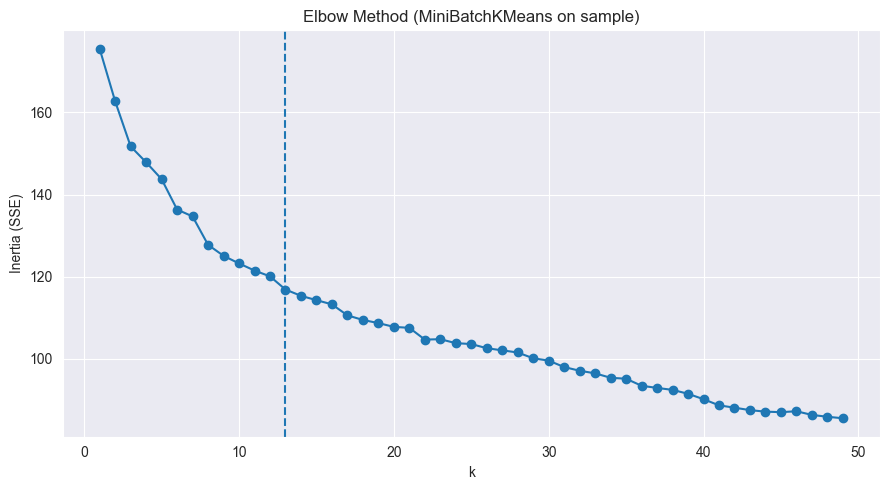

[OK] Saved plot: kmeans_elbow.png
[INFO] Transform full embeddings with PCA...
[INFO] Fitting final MiniBatchKMeans with k=13 on full data (N=529)...

Top cluster sizes:
cluster_kmeans
5     76
7     64
8     61
9     46
4     46
3     44
0     41
10    40
1     28
11    25
2     23
12    20
6     15
Name: count, dtype: int64

Smallest cluster sizes:
cluster_kmeans
5     76
7     64
8     61
9     46
4     46
3     44
0     41
10    40
1     28
11    25
2     23
12    20
6     15
Name: count, dtype: int64

[OK] Saved labels: results/kmeans_cluster_labels.csv


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

# =========================
# CONFIG
# =========================
RNG = 42
SAMPLE_N = 200_000          # elbow computed on sample (increase if you can)
USE_PCA = True
PCA_DIM = 50                # good default for SBERT embeddings
K_LIST = list(range(1, 50, 1))  # try 20..500 step 20; adjust for your scale
BATCH_SIZE = 8192

FINAL_COL = "cluster_kmeans"

assert len(ai_df) == emb.shape[0], "ai_df and emb must be aligned (same N)"
ai_df = ai_df.reset_index(drop=True)

# =========================
# 1) Normalize embeddings (cosine-friendly)
# =========================
emb = np.asarray(emb, dtype=np.float32)
emb_norm = emb / (np.linalg.norm(emb, axis=1, keepdims=True) + 1e-12)

N = emb_norm.shape[0]
n_s = min(SAMPLE_N, N)
idx = np.random.default_rng(RNG).choice(N, size=n_s, replace=False)
X_s = emb_norm[idx]

# Optional PCA for speed/stability
if USE_PCA:
    print(f"[INFO] PCA to {PCA_DIM} dims on sample...")
    pca = PCA(n_components=PCA_DIM, random_state=RNG)
    X_s_pca = pca.fit_transform(X_s)
else:
    pca = None
    X_s_pca = X_s

# =========================
# 2) Elbow curve (inertia vs k)
# =========================
inertias = []
print("[INFO] Computing inertia for K:", K_LIST)
for k in K_LIST:
    km = MiniBatchKMeans(
        n_clusters=k,
        random_state=RNG,
        batch_size=BATCH_SIZE,
        n_init="auto"
    )
    km.fit(X_s_pca)
    inertias.append(float(km.inertia_))
    print(f"  k={k:4d} inertia={inertias[-1]:.3e}")

# =========================
# 3) Auto elbow detection (max distance to line)
#    Works well on log(inertia).
# =========================
ks = np.array(K_LIST, dtype=float)
ys = np.log(np.array(inertias, dtype=float))

# line between first and last point
p1 = np.array([ks[0], ys[0]])
p2 = np.array([ks[-1], ys[-1]])

# distance from each point to the line (normalized)
# formula: |(p2-p1)x(p1-p)| / ||p2-p1||
v = p2 - p1
v_norm = np.linalg.norm(v) + 1e-12

dists = []
for k, y in zip(ks, ys):
    p = np.array([k, y])
    # 2D cross product magnitude
    cross = abs(v[0]*(p1[1]-p[1]) - v[1]*(p1[0]-p[0]))
    dists.append(cross / v_norm)

dists = np.array(dists)
best_i = int(np.argmax(dists))
best_k = int(ks[best_i])

print(f"\n[OK] Auto-elbow K = {best_k} (index={best_i})")

# Plot elbow
plt.figure(figsize=(9, 5))
plt.plot(K_LIST, inertias, marker="o")
plt.title("Elbow Method (MiniBatchKMeans on sample)")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.grid(True)
plt.axvline(best_k, linestyle="--")
plt.tight_layout()
plt.savefig("kmeans_elbow.png", dpi=300, bbox_inches="tight")
plt.show()
print("[OK] Saved plot: kmeans_elbow.png")

# =========================
# 4) Fit FINAL KMeans on ALL data
# =========================
if USE_PCA:
    print("[INFO] Transform full embeddings with PCA...")
    X_full = pca.transform(emb_norm)
else:
    X_full = emb_norm

print(f"[INFO] Fitting final MiniBatchKMeans with k={best_k} on full data (N={N})...")
final_km = MiniBatchKMeans(
    n_clusters=best_k,
    random_state=RNG,
    batch_size=BATCH_SIZE,
    n_init="auto"
)
labels_full = final_km.fit_predict(X_full)

ai_df[FINAL_COL] = labels_full

# Cluster size summary
sizes = ai_df[FINAL_COL].value_counts().sort_values(ascending=False)
print("\nTop cluster sizes:")
print(sizes.head(20))
print("\nSmallest cluster sizes:")
print(sizes.tail(20))

# Optional: save
ai_df[[FINAL_COL]].to_csv("results/kmeans_cluster_labels.csv", index=False)
print("\n[OK] Saved labels: results/kmeans_cluster_labels.csv")


Plotting Top-30 clusters: 529 / 529 (100.00%)


C:\Users\qswwq\AppData\Local\Temp\ipykernel_7940\2331364797.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(cats)) if len(cats) <= 20 else plt.cm.get_cmap("gist_ncar", len(cats))


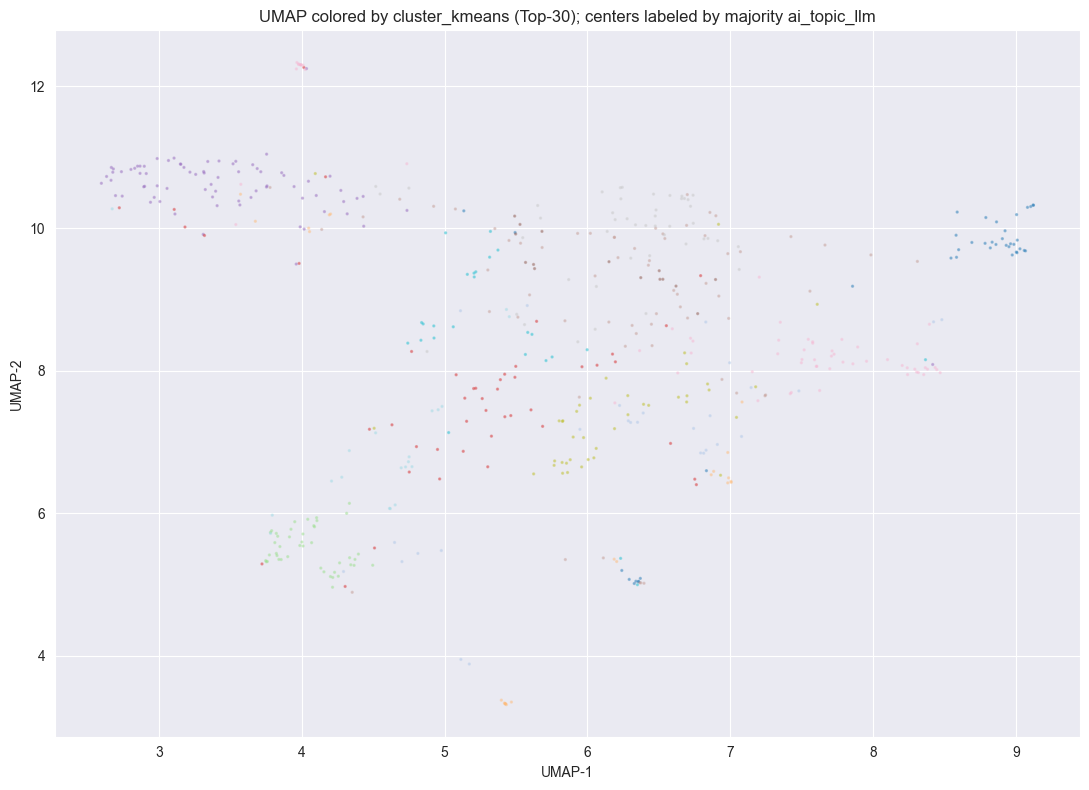

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------
# CONFIG
# -------------------
CLUSTER_COL = "cluster_kmeans"
TOPIC_COL   = "ai_topic_llm"

MAX_PTS = 200_000      # 散点抽样数（太大容易卡）
TOPK_PLOT = 30         # 只画最大的 Top-K 个簇（其余不画）——强烈推荐，否则太乱
TOPK_LABEL = 30        # 标注多少个簇的中心（建议与 TOPK_PLOT 一致）
MIN_LABEL_N = 200      # 小簇不标注（避免文字挤爆）
LABEL_MAX_CHARS = 22   # 标注文本截断长度

RNG = 42

# -------------------
# sanity
# -------------------
assert len(ai_df) == reduced.shape[0], "ai_df and reduced must align"
assert CLUSTER_COL in ai_df.columns, f"Missing {CLUSTER_COL}"
assert TOPIC_COL in ai_df.columns, f"Missing {TOPIC_COL}"

ai_df = ai_df.reset_index(drop=True)

# -------------------
# 1) pick Top-K clusters to plot (optional but recommended)
# -------------------
sizes = ai_df[CLUSTER_COL].value_counts()
top_clusters = sizes.head(TOPK_PLOT).index.to_numpy()

mask_top = ai_df[CLUSTER_COL].isin(top_clusters).to_numpy()
idx_all = np.where(mask_top)[0]
print(f"Plotting Top-{TOPK_PLOT} clusters: {len(idx_all)} / {len(ai_df)} ({len(idx_all)/len(ai_df):.2%})")

# sample only from selected clusters
idx = np.random.default_rng(RNG).choice(idx_all, size=min(MAX_PTS, len(idx_all)), replace=False)

x = reduced[idx, 0]
y = reduced[idx, 1]
c = ai_df.loc[idx, CLUSTER_COL].to_numpy()

# -------------------
# 2) compute cluster centers on FULL selected data (not just sample)
# -------------------
sub = ai_df.loc[idx_all, [CLUSTER_COL, TOPIC_COL]].copy()
sub["x"] = reduced[idx_all, 0]
sub["y"] = reduced[idx_all, 1]

# center (mean in reduced space)
centers = sub.groupby(CLUSTER_COL)[["x", "y"]].mean()

# majority ai_topic_llm per cluster (mode)
major_topic = (
    sub.groupby(CLUSTER_COL)[TOPIC_COL]
       .agg(lambda s: s.astype(str).value_counts().idxmax() if len(s) else "")
)

center_df = centers.join(major_topic.rename("major_topic"))
center_df["n_docs"] = sizes.loc[center_df.index].astype(int).values
center_df = center_df.sort_values("n_docs", ascending=False)

# choose which clusters to label
label_clusters = center_df.head(TOPK_LABEL).index.to_numpy()

# -------------------
# 3) plot
# -------------------
fig, ax = plt.subplots(figsize=(11, 8))

# Use categorical codes for coloring (works even if cluster ids are big numbers)
cat = pd.Series(c).astype("category")
codes = cat.cat.codes.to_numpy()
cats  = cat.cat.categories.to_numpy()

# discrete colormap with enough bins for TOPK_PLOT
cmap = plt.cm.get_cmap("tab20", len(cats)) if len(cats) <= 20 else plt.cm.get_cmap("gist_ncar", len(cats))

sc = ax.scatter(
    x, y,
    c=codes,
    s=2,
    alpha=0.35,
    cmap=cmap,
    rasterized=True
)

ax.set_title(f"UMAP colored by {CLUSTER_COL} (Top-{TOPK_PLOT}); centers labeled by majority {TOPIC_COL}")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")

# plot centers + labels
for cid in label_clusters:
    row = center_df.loc[cid]
    if row["n_docs"] < MIN_LABEL_N:
        continue

    cx, cy = row["x"], row["y"]
    topic = str(row["major_topic"]).strip().replace("\n", " ")
    if len(topic) > LABEL_MAX_CHARS:
        topic = topic[:LABEL_MAX_CHARS] + "…"

    ax.scatter([cx], [cy], marker="x", s=80, linewidths=2)  # center mark
    ax.text(
        cx, cy,
        f"{topic}",
        fontsize=9,
        ha="center", va="center",
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
    )

fig.tight_layout()
fig.savefig("umap_kmeans_clusters_labeled_by_ai_topic_llm.png", dpi=300, bbox_inches="tight")
plt.show()


In [14]:
np.unique(labels)

array([-1,  0,  1,  2,  3])

In [15]:
# 1) 先写入数值簇标签
ai_df["cluster"] = labels

# 2) 计算每个簇里出现最多的 ai_topic_llm（这就是你图里 labels_text 的逻辑）
cluster_to_topic = (
    ai_df.groupby("cluster")["ai_topic_llm"]
        .agg(lambda s: s.fillna("NA").astype(str).value_counts().idxmax())
)

# 3) 用这个“中心 topic”替换 cluster 列
ai_df["cluster"] = ai_df["cluster"].map(cluster_to_topic)

# 4) （可选）如果你想让噪声保持为 -1，而不是被替换成某个 topic，就加这一行
#     放在 map 之后，因为 map 会把 -1 也替换掉
ai_df.loc[labels == -1, "cluster"] = -1


In [19]:
cluster_to_topic
# ouput a random plain text from cluster 1


cluster
-1    automation technology
 0         AI in healthcare
 1    automation technology
 2    automation technology
 3         machine learning
Name: ai_topic_llm, dtype: object

In [20]:
CLUSTER_COL = "cluster"
TEXT_COL = "plain_text"
TITLE_COL = "title"            # 没有就删掉
DATE_COL = "published_date"    # 没有就删掉

TARGET_CLUSTER = 'automation technology'          # <<< 改这里：例如 -1 或 "policy" 等
condition = ai_df['ai_relevance_llm']>0
sub = ai_df[(ai_df[CLUSTER_COL] == TARGET_CLUSTER)&condition]
print("cluster =", TARGET_CLUSTER, "n =", len(sub))

if len(sub) == 0:
    print("No rows in this cluster.")
else:
    i = np.random.default_rng(np.random.randint(0,100)).choice(sub.index, size=1)[0]
    row = ai_df.loc[i]

    # 可选：打印元信息
    if TITLE_COL in ai_df.columns:
        print("\nTITLE:", row[TITLE_COL])
    if DATE_COL in ai_df.columns:
        print("DATE :", row[DATE_COL])
    print("INDEX:", i)

    # 输出正文
    print("\nPLAIN_TEXT:\n")
    print(str(row[TEXT_COL]))
    print(row)

cluster = automation technology n = 340

TITLE: Danske investeringer i kunstig intelligens eksploderer
DATE : 2018-01-03 00:00:00
INDEX: 430

PLAIN_TEXT:

Danske virksomheder investerer massivt i kunstig intelligens og er fint med internationalt, vurderer ekspert.  Danske virksomheder øger deres investeringer i kunstig intelligens massivt i disse år. Det betyder blandt andet, at Danmark er godt med internationalt, skriver Finans. Det vurderer en af verdens førende eksperter på området, danske Danny Lange.  - Jeg rejser rundt i hele verden, og mit indtryk er, at Danmark er fint med. Det går vildt stærkt med at indføre kunstig intelligens også her, siger Danny Lange. Der findes ingen præcise tal for danske investeringer i artificial intelligence (AI), som er den engelske betegnelse, men Anders Elbak fra analysevirksomheden IDC vurderer, at de er steget med cirka 50 procent fra 2016 til 2017. - Ud fra tallene for Europa vil et kvalificeret gæt være, at danske virksomheder i 2017 har inves

In [42]:
row

x                    7.947775
y                    2.162235
major_topic    AI integration
n_docs                     97
Name: 3, dtype: object

In [43]:
# 列名里有空格的话用这种写法
CLUSTER_COL = "cluster"
KEYWORD_COL = "keyword_score"   # <<< 这里换成你真实的 keyword score 列名（看你写法像有空格）

# 1) 每个 cluster 的 keyword_score 均值
cluster_kw = (
    ai_df.groupby(CLUSTER_COL)[KEYWORD_COL]
         .mean()
         .sort_values(ascending=False)
)

# 2) 最大均值的 cluster
best_cluster = cluster_kw.index[0]
best_mean = cluster_kw.iloc[0]

print("Best cluster by mean keyword score:")
print("cluster =", best_cluster, "mean_keyword_score =", best_mean)

# 3) 可选：把 top 20 打出来
print("\nTop 20 clusters:")
print(cluster_kw.head(20))


Best cluster by mean keyword score:
cluster = -1 mean_keyword_score = 3.697674418604651

Top 20 clusters:
cluster
-1                  3.697674
AI chip demand      2.587571
AI in healthcare    1.980796
Name: keyword_score, dtype: float64


In [44]:
# 列名里有空格的话用这种写法
CLUSTER_COL = "cluster"
KEYWORD_COL = "ai_score"   # <<< 这里换成你真实的 keyword score 列名（看你写法像有空格）

# 1) 每个 cluster 的 keyword_score 均值
cluster_kw = (
    ai_df.groupby(CLUSTER_COL)[KEYWORD_COL]
         .mean()
         .sort_values(ascending=False)
)

# 2) 最大均值的 cluster
best_cluster = cluster_kw.index[0]
best_mean = cluster_kw.iloc[0]

print("Best cluster by mean keyword score:")
print("cluster =", best_cluster, "mean_keyword_score =", best_mean)

# 3) 可选：把 top 20 打出来
print("\nTop 20 clusters:")
print(cluster_kw.head(20))

Best cluster by mean keyword score:
cluster = AI in healthcare mean_keyword_score = 0.4310545629012346

Top 20 clusters:
cluster
AI in healthcare    0.431055
AI chip demand      0.339508
-1                  0.337419
Name: ai_score, dtype: float64


In [56]:
print(df.columns)
print(df.shape)
print(df['is_ai_llm'].sum())
# check ai_topic_llm if is_ai_llm is True
ai_topics = df[df['is_ai_llm']==True]['ai_topic_llm']
print(ai_topics.value_counts().head(20))
# check  is_ai_llm is False but keyword_score > 0
false_ai_with_keyword = df[(df['is_ai_llm']==False) & (df['keyword_score']>0)]
print(false_ai_with_keyword)
# output plain_text of first row
print(false_ai_with_keyword.iloc[2]['plain_text'])

Index(['plain_text', 'published_date', 'title', 'tags', 'categories', 'author',
       'sitename', 'publisher', 'keyword_score', 'ai_score', 'is_ai',
       'orig_index', 'is_ai_llm', 'ai_relevance_llm', 'ai_topic_llm',
       'ai_barrier_llm', 'ai_barrier_type_llm', 'ai_barrier_summary_llm',
       'countries_llm', 'cities_llm', 'industries_llm', 'year',
       'is_ai_llm_flag', 'is_ai_flag', 'ai_barrier_llm_flag'],
      dtype='object')
(7101, 25)
1721
ai_topic_llm
AI in healthcare         71
AI ethics                47
automation technology    35
AI regulation            29
AI in education          21
AI investment            14
AI in finance            13
robot automation         12
AI integration           11
AI chatbots              11
AI adoption              11
AI-generated content      9
AI education              7
AI in Education           7
robotics growth           7
AI trading signals        7
AI chip demand            7
AI surveillance           6
AI chatbot              